# CDS Services

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week4/04_astrocds.ipynb)


Welcome to a Jupyter notebook demonstrating how to access some CDS services with Python. Jupyter notebooks offer an interactive way to use Python. If you are viewing this notebook with Binder you can execute every cell of code either by pushing the little 'play' <img src="https://github.com/Danselem/brics_astro/blob/main/Week4/images/jupyter_run-cell.png?raw=1" alt="" style="width:70px; display: inline-block;"/> symbol on the left of the cell (appears when the mouse pointer moves in its vincitity) or by selecting a cell and pressing 'Shift' + 'Enter' at the same time. Note that cells that have not yet been executed have no number assigned to them, later on they are assigned the number of the order in which they were executed. If they are run again, they get a new number.

The aim of this tutorial is to open an Aladin Lite widget, find and download a catalogue from Vizier and overlay the sources of this catalogue on the sky view in the Aladin Lite widget.

Python draws its power from the large variety of packages that are available for everyone to install and use. For this tutorial we will be using a few packages:
 - [`ipyaladin`](https://github.com/cds-astro/ipyaladin), allows to load Aladin Lite in a Jupyter notebook.
 - The `Vizier` and `cds` modules from the [`astroquery`](https://astroquery.readthedocs.io/en/latest/index.html#introduction) package, lets you query VizieR and the CDS MOCserver from this notebook.
 - [`pyVO`](https://pyvo.readthedocs.io/en/latest/) is a general package to query all VO-compliant archives.
 - [`MOCpy`](https://cds-astro.github.io/mocpy/index.html) provides all the necessary machinery to handle MOCs in Python.
 - [`astropy`](https://docs.astropy.org/en/stable/index.html) is the astronomy Python package.

Let's import these packages by running the following cell:

**Note**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [1]:
!pip install -q astroquery ipyaladin mocpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from astropy.coordinates import Angle, SkyCoord
from astroquery.vizier import Vizier
from astroquery.cds  import cds
import astropy.units as u
from ipyaladin import Aladin, Marker
from pathlib import Path
import pyvo
import mocpy
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Wednesday 4th from 11h to 12h


In [ ]:
from ipyaladin import __version__, __aladin_lite_version__
print("version:", __version__, "running Aladin Lite:", __aladin_lite_version__)

version: 0.6.0 running Aladin Lite: 3.6.5


In [ ]:
aladin = Aladin(
    survey="CDS/P/DECaPS/DR1/color",
    show_coo_grid=True,
    target="galactic center",
    coo_frame="galactic",
    fov=40,
    height=600,
)
aladin

Aladin(coo_frame='galactic', survey='CDS/P/DECaPS/DR1/color')

In [ ]:
aladin.target = "Antennae"

In [ ]:
aladin = Aladin(fov=20, reticle_size=64, reticle_color="#ff89ff")
aladin

Aladin()

In [ ]:


print('Hello there, the packages are imported and we are ready to go :)')

Hello there, the packages are imported and we are ready to go :)


## Start Aladin Lite
We start this tutorial by initialising Aladin Lite. In the first line of code we tell Python that the variable `aladin` is now assigned to an Aladin Lite widget. This widget is supposed to **center** on the Antennae galaxies, set a **field of view** of 0.7deg and show colour images from the DSS **survey**. Typing `aladin` in the second line of code, tells the notebook to display the widget.

As with any Aladin Lite implementation, you can interact with this widget:
 - to zoom in and out place you mouse pointer on top of the image and scroll.
 - with <img src="https://github.com/Danselem/brics_astro/blob/main/Week4/images/ipyaladin_layer.png?raw=1" alt="the Layer Button" style="width:30px; display: inline-block;"/>  you can select other image surveys and manage the current view.
 - if you like to look at another target, you can use the search field <img src="https://github.com/Danselem/brics_astro/blob/main/Week4/images/ipyaladin_search.png?raw=1" alt="the Search Button" style="width:30px; display: inline-block;"/> to get there.

These interactions can also be steered by changing properties of the variable `aladin`. If for example you wanted to focus on M101 instead of the Antennae galaxies, do:

In [ ]:
aladin.target = 'M101'

## Find and download tables from VizieR
Besides using Aladin we can also query VizieR from within this Jupyter notebook. To do so we use the `Vizier` subpackage from the `astroquery` package. As we remember from before, the catalogue of peculiar galaxies was called "Arp's peculiar galaxies" and was published by Webb. Hence, we ask `Vizier` to find all catalogues that have a match with the keywords 'Arp Webb' and write the result into the variable `catalog_list_arp` (first line of code). Then we tell Python to `print` out the query result in a readable way (second line of code).  

In [ ]:
catalog_list_arp = Vizier.find_catalogs('Arp')
for k, v in catalog_list_arp.items():
    print(k, ': ', v.description)

VII/74A :  Atlas of Peculiar Galaxies (Arp 1966)
VII/192 :  Arp's Peculiar Galaxies (Webb 1996)


Alternatively you can also search for the table with `pyvo` using the Table Access Protocol (TAP) to query VizieR. In this case, you first need to define the TAP endpoint of VizieR and then send a query written in ADQL (an SQL-like query language optimised for astronomy) to this endpoint. Finally we again print out the result of this query.

In [ ]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')
query = """SELECT  *  FROM tap_schema.tables
               WHERE table_name LIKE '%arp%' """
catalog_list_arp = tap_vizier.search(query).to_table()
catalog_list_arp['table_name', 'description']

table_name,description
object,object
VII/192/arplist,list and info for involved galaxies ( Webb D.)
J/A+A/664/A53/harps03,"RV data taken with HARPS spectrograph ( Stalport M., Delisle J.-B., Udry S., Matthews E., Bourrier V., Leleu A.)"
J/A+A/669/A39/sunharps,"HARPS detrended solar radial velocities ( Al Moulla K., Dumusque X., Figueira P., Lo Curto G., Santos N.C., Wildi F.)"
J/MNRAS/372/69/varphot,"CCD time-series V and R photometry of 30 variables in M2 (NGC7089) ( Lazaro C., Arellano Ferro A., Arevalo A., Bramich D.M., Giridhar S., Poretti E.)"
J/A+A/684/A22/harps,"S-BART extracted RVs from HARPS ( Passegger V.M., Suarez Mascareno A., Allart R., et al.)"
J/A+A/664/A53/harps15,"RV data taken with HARPS spectrograph ( Stalport M., Delisle J.-B., Udry S., Matthews E., Bourrier V., Leleu A.)"
J/A+A/693/A297/harps15,"HARPS data using YARARA v1 (08/2015-03/2024) ( Nari N., Dumusque X., Hara N.C., et al.)"
J/MNRAS/511/1043/harpsccf,"HARPS CCF SCALPELS data ( Wilson T.G., Goffo E., Alibert Y., et al.)"
J/A+A/693/A297/harps03,"HARPS data using YARARA v2 (09/2003-02/2015) ( Nari N., Dumusque X., Hara N.C., et al.)"


The catalogue that we are interested in today is "VII/192" and its description is "Arp's Peculiar Galaxies (Webb 1996)". In the TAP query we already see that there are two tables in this catalogue: `VII/192/arplist` and `VII/192/arpord`. To be able to work with these data, let's load them into this notebook.

Again we can use either `astroquery` or `pyvo`. Which one you chose is up to you and which one you like better. Attention **Spoiler:** over the week you'll learn more about TAP and ADQL.

In oder to get the full catalogue with `astroquery`, we first set the row limit to infinite (i.e. `-1` in the notation of this package) and then ask `Vizier` to write the content of the catalogue into the variable `catalogs_arp` (second line):

In [ ]:
Vizier.ROW_LIMIT = -1
catalogs_arp = Vizier.get_catalogs('VII/192')

Now let's inspect, what we got:

In [ ]:
print(catalogs_arp)

TableList with 2 tables:
	'0:VII/192/arpord' with 12 column(s) and 338 row(s) 
	'1:VII/192/arplist' with 13 column(s) and 592 row(s) 


As we have seen in the first part of the tutorial, the catalogue "Arp's Peculiar Galaxies (Webb 1996)" comes with two tables: arpord and arplist. As you can see from the printout `Vizier` has downloaded both of them. However, we are still only interested in the arplist (index `1` in the TableList). Therefore, we make Python write only the arplist table into a new variable `table_arplist` (first line) and then display the table (second line):

In [ ]:
table_arplist = catalogs_arp[1]
table_arplist

Arp,Name,VT,u_VT,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000,Simbad,NED
,,mag,,arcmin,arcmin,,,,,,,
int16,str16,float32,str1,float32,float32,str1,str14,int16,str10,str9,str6,str3
249,UGC 12891,16.2,,--,--,,,--,00 00 19.3,+22 59 26,Simbad,NED
249,UGC 12891,16.2,,1.3,0.5,,,--,00 00 21.6,+22 59 42,Simbad,NED
112,NGC 7805,13.3,,1.2,0.9,,SAB0^0: pec,89,00 01 26.9,+31 26 02,Simbad,NED
112,NGC 7806,13.5,,1.1,0.8,,SA(rs)bc? pec,89,00 01 30.2,+31 26 33,Simbad,NED
130,IC 5378,15.6,,0.5,--,,SBc,--,00 02 37.7,+16 39 08,Simbad,NED
130,IC 5378,15.3,,--,--,,E,--,00 02 37.8,+16 38 37,Simbad,NED
51,MGC-02-01-24,15.0,,0.8,--,,,--,00 06 16.8,-13 26 53,Simbad,NED
144,NGC 7828,14.4,,0.9,0.5,,Ring A,260,00 06 27.1,-13 24 58,Simbad,NED


Nice, we got the data we want. Before we move on, let's have a look at how we can use `pyVO` to get the same table. Just for safety we define again the VizieR TAP endpoint. It is the same one as above, but if the cells of this notebook are not run one after another, this safety measure ensure we always query the right service.

Then we write a simple query telling VizieR that we want all the rows and all the columns from the table `VII/192/arplist`. Note that we have to encompass the table name with quotation marks due to the special character `/` in the table name.

In [ ]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')
query = """SELECT  *  FROM "VII/192/arplist" """
table_arplist = tap_vizier.search(query).to_table()
table_arplist

recno,Arp,Name,VT,u_VT,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000
,,,mag,,arcmin,arcmin,,,,deg,deg
int32,int16,object,float64,str1,float64,float64,str1,object,int16,float64,float64
112,333,NGC 1024,12.1,,3.9,1.4,,(R')SA(r)ab,175,39.80083333333333,10.847222222222221
120,200,NGC 1134,12.1,,2.5,0.9,,S?,175,43.42124999999999,13.015277777777776
119,190,UGC 02320,15.2,,0.5,0.3,,Multiple Sys,--,42.58291666666666,12.889444444444443
89,290,IC 0195,14.3,,1.6,0.8,,S0,--,30.935833333333328,14.708611111111109
90,290,IC 0196,14.2,,2.8,1.4,,S0-,--,30.95833333333333,14.73972222222222
111,258,UGC 02140A,15.5,,0.9,0.2,,SB.0*/,--,39.78874999999999,18.367499999999996
110,258,UGC 02140,15.4,,1.7,0.7,,IBS9P,--,39.77583333333333,18.382777777777775
109,258,Hickson 18C,16.1,,--,--,,S?,--,39.774583333333325,18.388333333333332


There we go, we now know two nifty ways to get VizieR tables with Python. Obviously there are many other things you can do with this tools. For example if you set your TAP endpoint to `http://simbad.u-strasbg.fr:80/simbad/sim-tap` instead of the VizieR enpoint, you can query SIMBAD just like that.

Note that not all rows but only the first and last 10 rows for all columns are shown in the display. To finish off this little excursion, we now want to visualise the location of the entries of this table in our Aladin Lite widget. To do so, we tell Python to take the variable `aladin` (remember that this was the name of the widget) and add the table `table_arplist` to it:

In [ ]:
aladin.add_table(table_arplist)

Now scroll back up to the Aladin Lite widget. You will find that the location of the sources in the arplist table are marked with coloured symbols. Again you can zoom in and out to look at the different sources. If you click on one of the colour symbols, you will be able to see the corresponding row in the bottom of the Aladin Lite widget.

Note if you are using Jupyter Lab instead of single Jupyter notebooks, you can open two notebooks that share a kernel. Then one notebook could contain your working environment, where you get and work on your tables ect. The other notebook could contain the Aladin Lite widget, and just remain visible all the time. This way there would be no need to scroll up and down.

## Bonus: MOCs and Python

As in the .pdf tutorial we can use MOCs to find out whether any of these galaxies has been observed both by SDSS and GALEX. For this task we use the `cds` module of `astroquery` and in the background the functionalities of `MOCpy` to get the intersection of the MOCs and to filter a table by a MOC. First let's query the MOC server for all things SDSS and all things GALEX.

In [ ]:
info_sdss = cds.find_datasets(meta_data="ID=*SDSS*")
info_sdss[['ID']]

ID
str25
CDS/J/ApJ/749/10/SDSS-obs
CDS/P/HLA/SDSSg
CDS/P/HLA/SDSSr
CDS/P/HLA/SDSSz
CDS/P/HST/SDSSg
CDS/P/HST/SDSSr
CDS/P/HST/SDSSz
CDS/P/SDSS9/color
CDS/P/SDSS9/color-alt


In [ ]:
info_galex = cds.find_datasets(meta_data="ID=*GALEX*")
info_galex[['ID']]

ID
str24
CDS/P/GALEXGR6/AIS/FUV
CDS/P/GALEXGR6/AIS/NUV
CDS/P/GALEXGR6/AIS/color
CDS/P/GALEXGR6_7/FUV
CDS/P/GALEXGR6_7/NUV
CDS/P/GALEXGR6_7/color


Now that we know what the relevat data sets are called, we can move on to download the corresponding MOCs:

**Querying Gaia Data with Astroquery**

This Jupyter notebook demonstrates how to use astroquery to access data from the Gaia mission.
We'll cover:

Installing required packages

Basic Gaia queries

Cone searches

Cross-matching with other catalogs

Saving results

Simple visualization


In [ ]:
login = False

if login:
    Gaia.login(user='your_username', password='your_password')
else:
    print("Using anonymous access (query limits may apply)")

Using anonymous access (query limits may apply)


In [ ]:
ngc1960 = SkyCoord.from_name('NGC 1960')
print(f"NGC 1960 coordinates: RA = {ngc1960.ra.degree:.4f}°, Dec = {ngc1960.dec.degree:.4f}°")

NGC 1960 coordinates: RA = 84.0840°, Dec = 34.1350°


In [ ]:
# Cone search parameters
radius = 0.5 * u.deg  # Search radius (cluster is about 10' across)
max_mag = 18  # Maximum G magnitude

# ADQL query for basic cluster members
query_basic = f"""
SELECT
source_id, ra, dec, parallax, pmra, pmdec,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
radial_velocity,
astrometric_excess_noise,
ruwe
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec), CIRCLE('ICRS', {ngc1960.ra.degree}, {ngc1960.dec.degree}, {radius.value}))
AND phot_g_mean_mag < {max_mag}
"""

# Execute the query
job_basic = Gaia.launch_job(query_basic)
results_basic = job_basic.get_results()

print(f"Found {len(results_basic)} stars in the region")
results_basic[:5].show_in_notebook()  # Display first 5 results

Found 2000 stars in the region


         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,astrometric_excess_noise,ruwe
,,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,km / s,mas,
0,3449281981948198528,84.2092989093278,33.64758676043744,0.4888740610001599,0.8492307100622158,-3.4253109583658787,16.737526,17.272726,16.04856,--,0.0,1.0213431
1,3449281986244111360,84.2031507891566,33.64683526390027,0.13836486241602355,0.9051685945304175,-2.5280306612593666,15.8599615,16.894186,14.851797,--,0.0,1.0052266
2,3449282020603846144,84.21831072016685,33.65119294127119,0.7262862742524924,0.5864728561461979,-2.831117404974683,16.341623,16.890219,15.610416,--,0.4092229,1.448924
3,3449282123679477760,84.17462084452235,33.64356922851392,0.13197139476001468,1.0049118628880427,-0.7430823408729322,16.695637,17.13668,16.06773,--,0.0,0.98351026
4,3449282123683070208,84.1650907250392,33.65097267004864,-0.017077797394560557,0.5767866171955416,-0.6409641957576434,16.977104,18.04037,15.971061,--,0.07439784,1.0150284


In [ ]:
# Basic query to get some Gaia data
query = """
SELECT TOP 2000
source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 10
ORDER BY phot_g_mean_mag
"""

job = Gaia.launch_job(query)
results = job.get_results()

# Display the first few results
results[:5]

source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32
418551920284673408,10.12724197930297,56.53718879378639,14.090976249252234,49.12564571845064,-31.595374311196693,1.9425238,2.9869862,1.8435026,1.1434835
4357027756659697664,243.58621066034064,-3.694967708333353,20.411292350652413,-45.34001940987892,-144.43272215287442,2.0164251,3.482232,1.9189217,1.5633104
4993479684438433792,6.57215550145885,-42.30782032569077,39.91825815729799,176.2682926212513,-398.87213472266046,2.0899775,3.301706,2.032224,1.2694821
4038055447778237312,274.4060904518451,-36.76242931758906,23.885852068095137,-131.80407046542277,-166.30893037257962,2.1164951,3.742679,1.9154117,1.8272674
1279798794197267072,221.24648617076684,27.074315757773466,13.82667260913517,-50.81825554241812,21.02352084436887,2.1833525,3.2867486,2.1027422,1.1840065


In [ ]:
results.write('m45_all.fits',format="fits", overwrite=True)

# Save to CSV
results.write('m45_all.csv', format="csv", overwrite=True)

print("Saved results to FITS and CSV formats")

Saved results to FITS and CSV formats


In [ ]:
%%html
<div style="text-align:center;">
<iframe src="https://gea.esac.esa.int/archive/" width="960" height="740"></iframe>
</div>

In [ ]:
#Now we can read the csv file into a pandas dataframe

all_stars = pd.read_csv('m45_all.csv') # I renamed my csv file to 'm5.csv' and put it in the the subfolder 'data'

#Checking the top few rows of the data and the number of rows and columns
print("(Rows, Columns) =", all_stars.shape)
all_stars.head()

(Rows, Columns) = (2000, 10)


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp
0,418551920284673408,10.127242,56.537189,14.090976,49.125646,-31.595374,1.942524,2.986986,1.843503,1.143484
1,4357027756659697664,243.586211,-3.694968,20.411292,-45.340019,-144.432722,2.016425,3.482232,1.918922,1.563310
2,4993479684438433792,6.572156,-42.307820,39.918258,176.268293,-398.872135,2.089978,3.301706,2.032224,1.269482
3,4038055447778237312,274.406090,-36.762429,23.885852,-131.804070,-166.308930,2.116495,3.742679,1.915412,1.827267
4,1279798794197267072,221.246486,27.074316,13.826673,-50.818256,21.023521,2.183352,3.286749,2.102742,1.184006


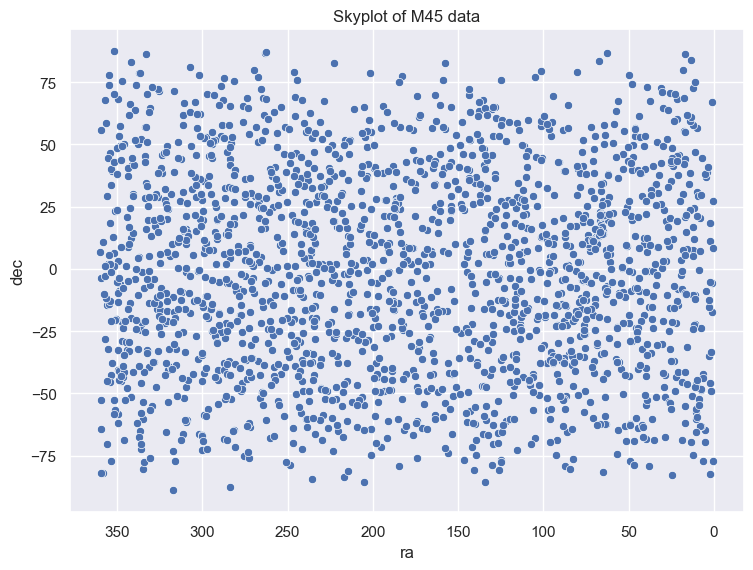

In [ ]:
## plotting the skyplot

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
#skyplot = sns.scatterplot(x='ra', y='dec', data = members)
skyplot.invert_xaxis()
plt.title('Skyplot of M45 data')
plt.show()

/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_9992/533507744.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',


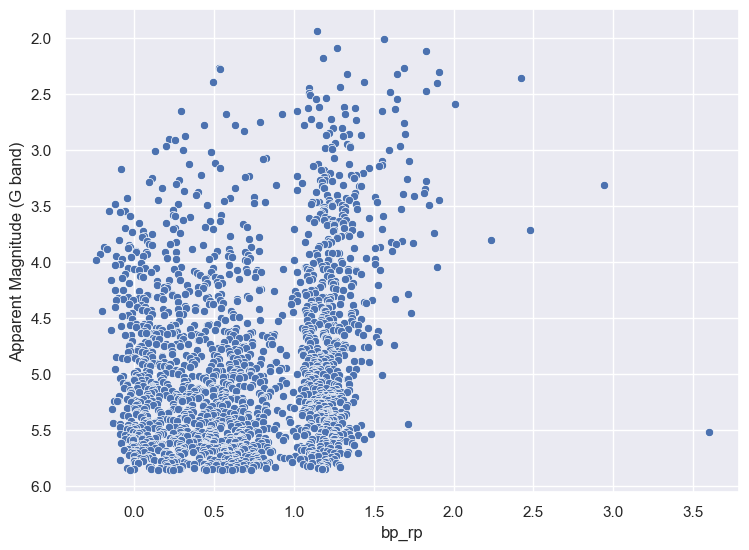

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = all_stars)
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()

/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_9992/2280469541.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


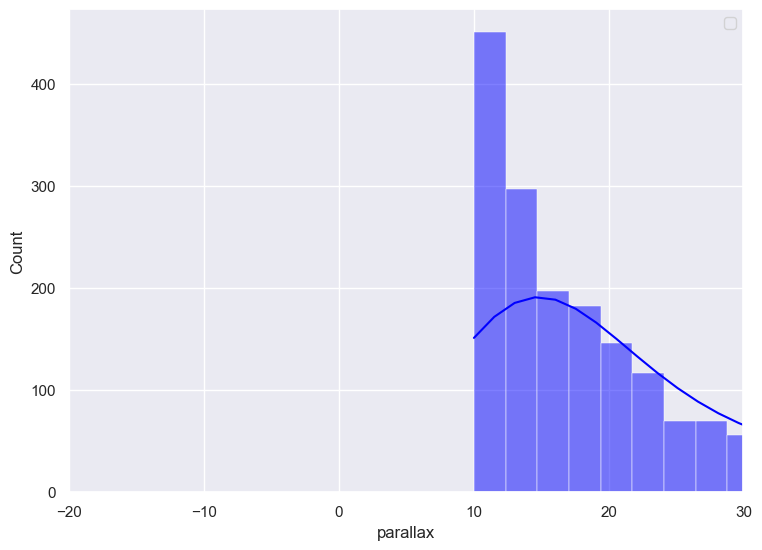

In [ ]:
sns.histplot(x='parallax', data=all_stars,
              kde=True,color='blue')
#sns.histplot(x='parallax', data=rf_member, label='RF Member',
 #            kde=True,color='Green')
plt.legend()
plt.xlim([-20,30])
plt.show()

(-60.0, 30.0)

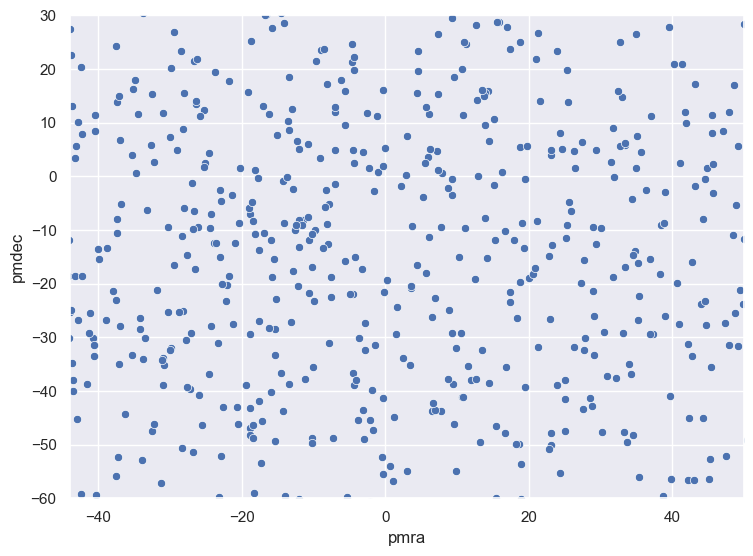

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,6.27)})

#sns.scatterplot(x='pmra', y='pmdec', data=features[features.labels > -1], hue='labels',legend='full')

sns.scatterplot(x='pmra', y='pmdec', data=all_stars)
plt.xlim([-44,50])
plt.ylim([-60,30])

In [ ]:
mask = (all_stars.parallax >= 6) & (all_stars.parallax <= 8.5) &(all_stars.pmra < 30) & (all_stars.pmra > 10)& (all_stars.pmdec > -50) & (all_stars.pmdec < -40)


In [ ]:
members = all_stars[mask]

/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_9992/3127956097.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_9992/3127956097.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',


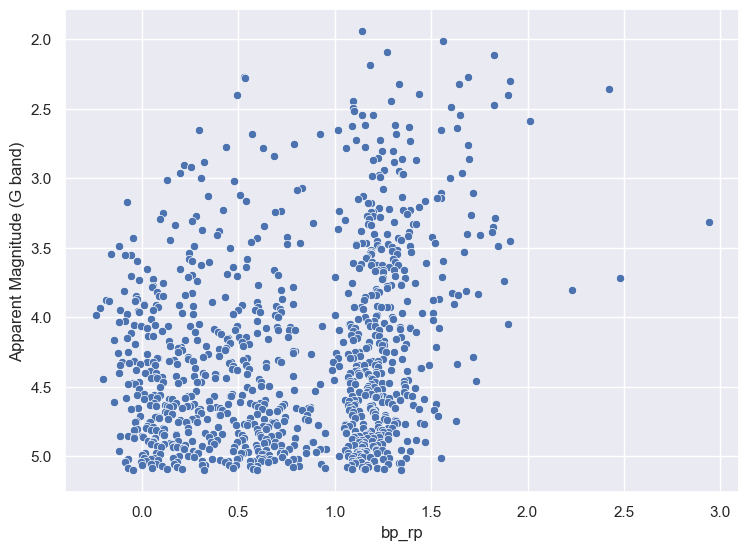

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = all_stars)
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = members)
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()

/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_9992/3329751562.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',


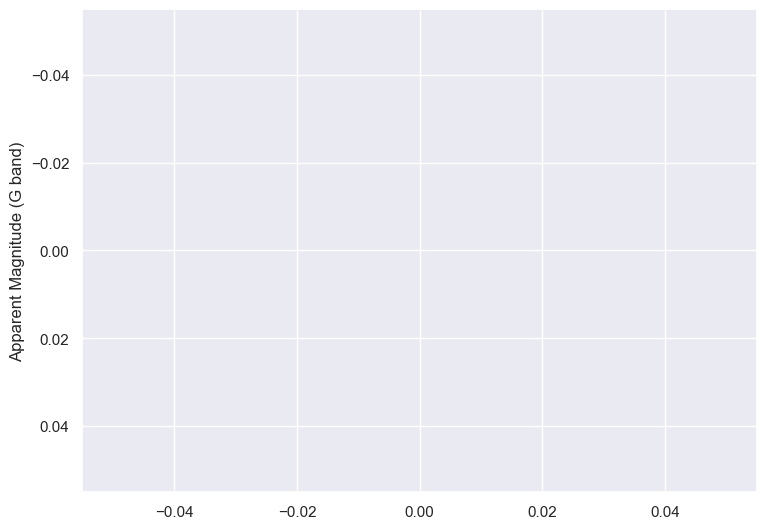

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = members)
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()